In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from PIL import Image
import cv2 
import os
import glob
import random
from tqdm import  tqdm
import Augmentor 
from scipy import ndimage
import scipy.ndimage.filters as filters

(1024, 2048, 4)


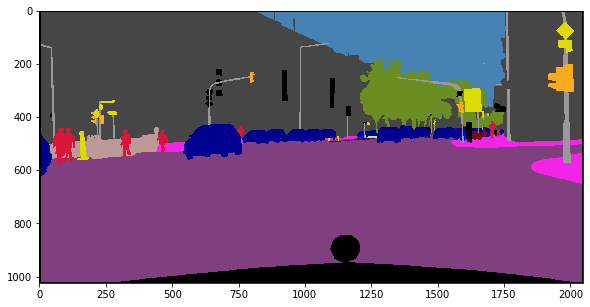

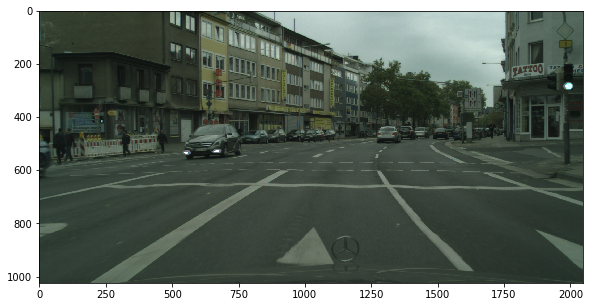

In [3]:
dir_lable=r"C:\Users\RENT\m\CityScapes\gtFine\train\aachen"

dir_data=r"C:\Users\RENT\m\CityScapes\leftImg8bit\train\aachen"

sorce_img_lable="aachen_000004_000019_gtFine_color.png"
sorce_img_data="aachen_000004_000019_leftImg8bit.png"
path_img1=os.path.join(dir_lable, sorce_img_lable)

path_data_img=os.path.join(dir_data, sorce_img_data)


img_lable=plt.imread(path_img1)
print(img_lable.shape)
img_data=plt.imread(path_data_img)
plt.figure(figsize=(10,5))
imshow(img_lable)
plt.figure(figsize=(10,5))
imshow(img_data)


In [4]:
# img[10][8]
img_lable.shape

(1024, 2048, 4)

## Find traffic lights

In [5]:

def find_traffic(img_lable):
    mask=((img_lable[:,:,0]==250/255) &(img_lable[:,:,1]==170/255) &(img_lable[:,:,2]==30/255))
    return mask




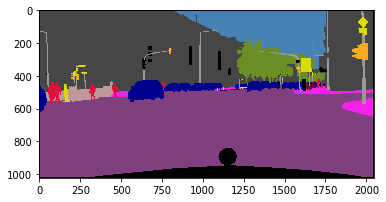

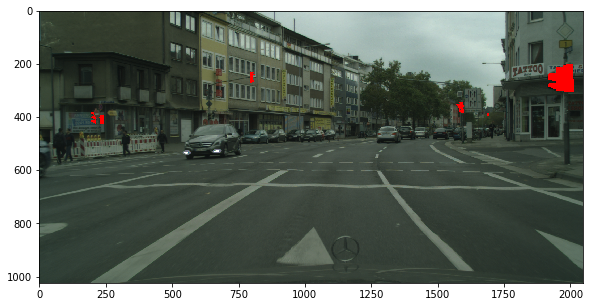

In [6]:
imshow(img_lable)
mask=find_traffic(img_lable)

copy_img=img_data.copy()
copy_img[mask]=[1,0,0]
plt.figure(figsize=(10,5))
imshow(copy_img)


# traffic lights attention

#### high pass filter

In [7]:
def high_pass_filter(img):
    highpass_filter = np.array([[-1/9, -1/9, -1/9],
                   [-1/9,  8/9, -1/9],
                   [-1/9, -1/9, -1/9]])

    return ndimage.convolve((img[:,:,1]), highpass_filter)#filter on the red image



#### Finding local maximum

In [8]:
def finding_local_maximum(img):
  
    highpass_filter=high_pass_filter(img)
    img_maximum = filters.maximum_filter(highpass_filter,35)
    return img_maximum

   
    
    

#### finding candidates

In [9]:
def finding_candidates(img):
    local_maximum = finding_local_maximum(img)
    candidates_mask = local_maximum>img[:,:,1]

    
    return candidates_mask
    

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


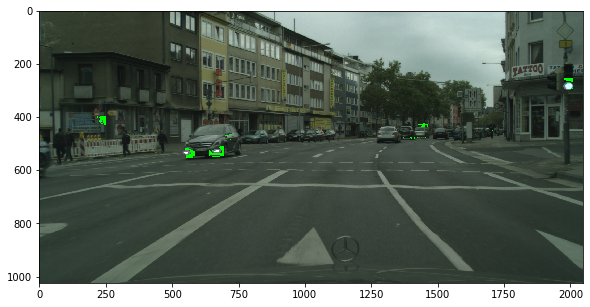

In [10]:
# dir_path=r"C:\Users\RENT\m\CityScapes\leftImg8bit\train\erfurt"

# path_img=os.path.join(dir_path, "erfurt_000015_000019_leftImg8bit.png")


candidates_mask=finding_candidates(img_data)

plt.figure(figsize=(10,5))
image_coordinates=img_data.copy()
image_coordinates[candidates_mask]=[0,1,0]
imshow(image_coordinates)
print(candidates_mask)
# imshow(img)

## Crop image to size (81,81,3)

In [11]:

def crop_traffic_sample(mask,img_data): 
    mask_coordinates=finding_candidates(img_data) 
#     i, j = np.where((mask == True) & (mask_coordinates==True))#all point with traffic
    i, j = np.where(mask == True)#all point with traffic
 
    i+=40
    j+=40       
  
    img_padding = np.pad(img_data, ((40,40), (40,40),(0,0)),mode='constant', constant_values=0)
    img_height,img_width=img_padding.shape[:2]
    size =81//2
    index=random.randint(0,len(i)-1) 
    x ,y = i[index],j[index]
    return img_padding[x-size:x+size+1,y-size:y+size+1]


In [12]:
def crop_without_traffic_sample(mask,img_data):
    mask_coordinates=finding_candidates(img_data)  
    i, j = np.where((mask == False) & (mask_coordinates==True))#all point with traffic
    i+=40
    j+=40
    img_padding = np.pad(img_data, ((40,40), (40,40),(0,0)),mode='constant', constant_values=0)
    img_height,img_width=img_padding.shape[:2]
    size =81//2
    index=random.randint(0,len(i)-1) 
    x ,y = i[index],j[index]
    return img_padding[x-size:x+size+1,y-size:y+size+1]
#     return None


### sample with traffic

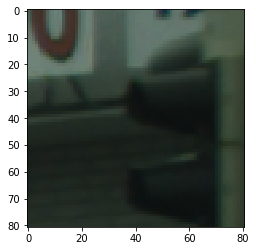

In [13]:
mask=find_traffic(img_lable)
traffic_sample=crop_traffic_sample(mask,img_data)
imshow(traffic_sample)


### sample without traffic

(81, 81, 3)


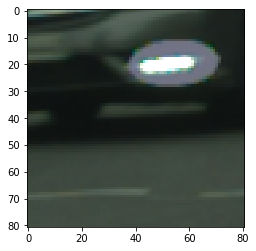

In [25]:
without_traffic_sample=crop_without_traffic_sample(mask,img_data)
(without_traffic_sample)
imshow(without_traffic_sample)
print(without_traffic_sample.shape)


# without_traffic_sample.tofile('test')

### open folders: train,validtion,test

In [15]:
#Database location on Disk
gt_dir = r'C:\Users\RENT\m\CityScapes\gtFine'
imgs_dir = r'C:\Users\RENT\m\CityScapes\leftImg8bit'

# Import data
gt_train_path = os.path.join(gt_dir, 'train')
imgs_train_path = os.path.join(imgs_dir, 'train')
gt_val_path = os.path.join(gt_dir, 'val')
imgs_val_path = os.path.join(imgs_dir, 'val')
gt_test_path = os.path.join(gt_dir, 'test')
imgs_test_path = os.path.join(imgs_dir, 'test')
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*color.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

### Create samples for all data

In [16]:
def create_sample(img_data_array,img_label_array, dir_name):
   
    data_dir_path = 'data_dir/'+ dir_name+'/data1.bin'
    label_dir_path='data_dir/'+ dir_name+'/labels1.bin'
    num_samples = 3
    with open(data_dir_path, 'ab') as f_data, open(label_dir_path,'ab') as f_label:
        for i in tqdm(range(len(img_data_array))):
            img_data_path=img_data_array[i]
            
            img_label_path=img_label_array[i]
            img_label=imread(img_label_path)
            img_data=imread(img_data_path)
            
            mask=find_traffic(img_label)
            mask_coordinates=finding_candidates(img_data)  
            i, j = np.where((mask == False) & (mask_coordinates==True))#all point with traffic
            if any(mask) and len(i)>0:#If there is a traffic light in the picture
                for j in range(num_samples):
                    without_traffic_sample=crop_without_traffic_sample(mask,img_data)
                    traffic_sample=crop_traffic_sample(mask,img_data)
                    #save data and labels
            
                    traffic_sample=(traffic_sample*255).astype(np.uint8)
                    without_traffic_sample=(without_traffic_sample*255).astype(np.uint8)
                    
                    traffic_sample.tofile(f_data)
                    without_traffic_sample.tofile(f_data)
                    np.array([1],dtype=np.uint8).tofile(f_label)
                    np.array([0],dtype=np.uint8).tofile(f_label)  
                              
   

In [17]:

create_sample(train_imgs, train_gt,'train')
create_sample(val_imgs, val_gt ,'val')
# create_sample(test_imgs, test_gt,'test')

100%|██████████| 500/500 [13:26<00:00,  1.61s/it]


## data augmentation

In [20]:
def data_augmentation(dir_name):
    data_dir_path = 'data_dir/'+ dir_name+'/data1.bin'
    label_dir_path='data_dir/'+ dir_name+'/labels1.bin'
    image_size=81*81*3
    image_num = int(os.path.getsize(data_dir_path)/image_size)
    with open(data_dir_path, 'ab+') as data_file, open(label_dir_path,'ab+') as label_file:
        for idx in tqdm(range(image_num)):
            data = np.memmap(data_file,  dtype='uint8', mode='r', shape=(81,81,3), offset = image_size*idx)
            label = np.memmap(label_file,  dtype='uint8', mode='r', shape=(1,), offset = idx)
            fliped_image=data[:,::-1]
            fliped_image.tofile(data_file)
            label.tofile(label_file)

In [21]:
data_augmentation("train")
data_augmentation("val")
# data_augmentation("test")

100%|██████████| 1746/1746 [00:03<00:00, 455.12it/s]


## Read binary file with memmap

In [22]:
def show_sample(file_name,idx, crop_size):
    data_file_name=file_name+'/data1.bin'
    label_file_name=file_name+'/labels1.bin'
    with open(data_file_name, 'r') as data_file, open(label_file_name, 'r') as label_file:
        data = np.memmap(data_file,  dtype='uint8', mode='r', shape=(81,81,3), offset = crop_size[0]*crop_size[1]*crop_size[2]*idx)
        label = np.memmap(label_file,  dtype='uint8', mode='r', shape=(1,), offset = idx)
        plt.imshow(data)
        plt.title("Traffic light" if  label else "Not Traffic light")
        plt.figure()

# testting

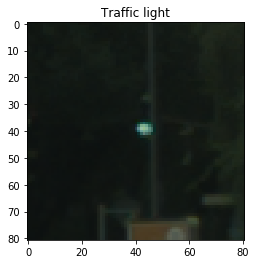

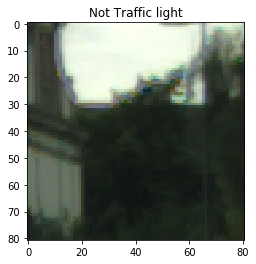

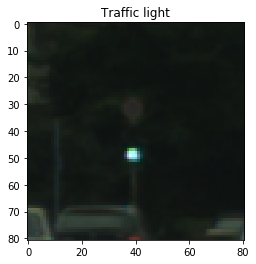

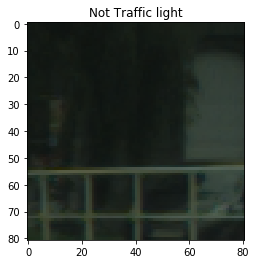

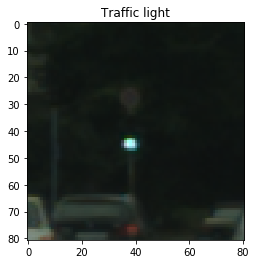

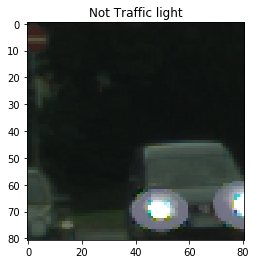

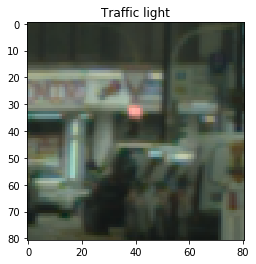

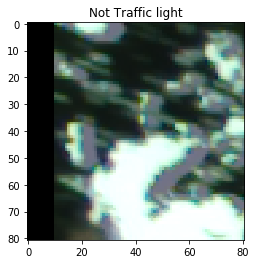

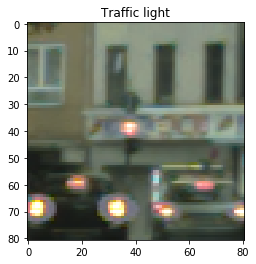

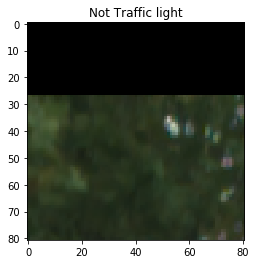

<Figure size 432x288 with 0 Axes>

In [23]:
data_path ="data_dir/train"
# image_num = int(os.path.getsize(data_path+"/data1.bin")/image_size)
for i in range(10):
#     index=random.randint(0,len(i)-1)
    show_sample(data_path,i,(81,81,3))
